In [77]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_error

In [78]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('../Datasets/AMD Historical Data.csv')
df1=df.reset_index()['Price']

In [79]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [80]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [81]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [82]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [83]:
print(X.shape)
print(y.shape)

(1511, 100)
(1511,)


In [84]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(866, 100)
(322, 100)
(323, 100)


In [85]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [86]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(866, 100)
(322, 100)
(323, 100)


In [87]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [88]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [89]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


14/14 [==============================] - 2s 39ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 2/100
14/14 [==============================] - 0s 27ms/step - loss: 5.2197e-04 - val_loss: 0.0092
Epoch 3/100
14/14 [==============================] - 0s 23ms/step - loss: 3.4029e-04 - val_loss: 0.0045
Epoch 4/100
14/14 [==============================] - 0s 28ms/step - loss: 2.8296e-04 - val_loss: 0.0045
Epoch 5/100
14/14 [==============================] - 0s 22ms/step - loss: 2.6203e-04 - val_loss: 0.0039
Epoch 6/100
14/14 [==============================] - 0s 22ms/step - loss: 2.4760e-04 - val_loss: 0.0036
Epoch 7/100
14/14 [==============================] - 0s 20ms/step - loss: 2.3819e-04 - val_loss: 0.0033
Epoch 8/100
14/14 [==============================] - 0s 20ms/step - loss: 2.2834e-04 - val_loss: 0.0028
Epoch 9/100
14/14 [==============================] - 0s 28ms/step - loss: 2.2246e-04 - val_loss: 0.0026
Epoch 10/100
14/14 [==============================] - 0s 20ms/step - loss: 2.234

In [90]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

11/11 [==============================] - 0s 6ms/step


In [91]:
print(y_pred.shape)

(322, 1)


In [92]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [93]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 87.33537853916894
Validation MAE: 85.99053308263137
Testing RMSE: 102.30168380833466
Testing MAE: 100.11992104037468


In [94]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.74169385]
101
1 day input [0.34650217 0.35719911 0.37872424 0.3840399  0.39066807 0.40208689
 0.4033994  0.4072713  0.400315   0.38180864 0.39729623 0.43969025
 0.4276808  0.42905893 0.43069957 0.43227458 0.41291508 0.43063394
 0.49291246 0.51699698 0.50242814 0.48661242 0.50124688 0.49324058
 0.48352802 0.47217483 0.48300302 0.50150938 0.49645623 0.46298727
 0.45261845 0.44126526 0.44021525 0.46082163 0.44992781 0.45439034
 0.45314346 0.45124032 0.46534978 0.47243733 0.47007481 0.47630923
 0.49770311 0.48890931 0.47998425 0.47565297 0.5113532  0.52598766
 0.57140045 0.579538   0.57277858 0.56700354 0.57783174 0.5955506
 0.58025988 0.57146607 0.55801286 0.56805355 0.5798005  0.58065363
 0.57113794 0.56660979 0.54488778 0.54429715 0.5640504  0.55453472
 0.5433784  0.54180339 0.53957212 0.52723455 0.52664392 0.52769392
 0.52880956 0.51778449 0.5121407  0.48739992 0.50144376 0.51128757
 0.52395327 0.52605329 0.52749705 0.47309358 0.50584066 0.52703767
 0.56116288 0.56129413 0.57415671 

1 day output [[0.7400452]]
2 day input [0.35719911 0.37872424 0.3840399  0.39066807 0.40208689 0.4033994
 0.4072713  0.400315   0.38180864 0.39729623 0.43969025 0.4276808
 0.42905893 0.43069957 0.43227458 0.41291508 0.43063394 0.49291246
 0.51699698 0.50242814 0.48661242 0.50124688 0.49324058 0.48352802
 0.47217483 0.48300302 0.50150938 0.49645623 0.46298727 0.45261845
 0.44126526 0.44021525 0.46082163 0.44992781 0.45439034 0.45314346
 0.45124032 0.46534978 0.47243733 0.47007481 0.47630923 0.49770311
 0.48890931 0.47998425 0.47565297 0.5113532  0.52598766 0.57140045
 0.579538   0.57277858 0.56700354 0.57783174 0.5955506  0.58025988
 0.57146607 0.55801286 0.56805355 0.5798005  0.58065363 0.57113794
 0.56660979 0.54488778 0.54429715 0.5640504  0.55453472 0.5433784
 0.54180339 0.53957212 0.52723455 0.52664392 0.52769392 0.52880956
 0.51778449 0.5121407  0.48739992 0.50144376 0.51128757 0.52395327
 0.52605329 0.52749705 0.47309358 0.50584066 0.52703767 0.56116288
 0.56129413 0.57415671 0.5

Validation RMSE: 87.33537853916894
Validation MAE: 85.99053308263137
Testing RMSE: 102.30168380833466
Testing MAE: 100.11992104037468


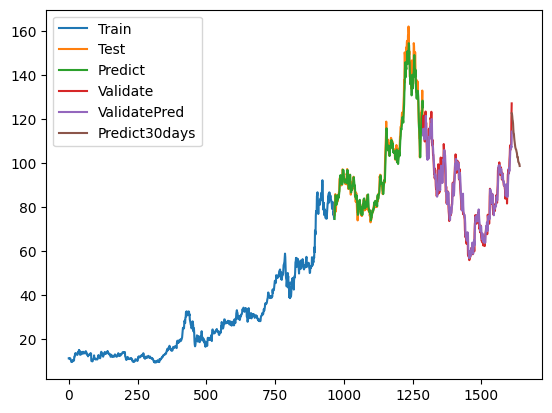

[[0.7416938543319702], [0.7400451898574829], [0.7328792214393616], [0.7226511240005493], [0.719050407409668], [0.7104491591453552], [0.6931706666946411], [0.6819272041320801], [0.6809911727905273], [0.6696071624755859], [0.6608120799064636], [0.6542466282844543], [0.6474184393882751], [0.6411305665969849], [0.6375232338905334], [0.6346939206123352], [0.6340493559837341], [0.6299100518226624], [0.6261330842971802], [0.6228616833686829], [0.6146851778030396], [0.6099033951759338], [0.6110736727714539], [0.604264497756958], [0.596502423286438], [0.5959800481796265], [0.5941137075424194], [0.5912880897521973], [0.5909075140953064], [0.5847753882408142]]


In [95]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()
print(lst_output)

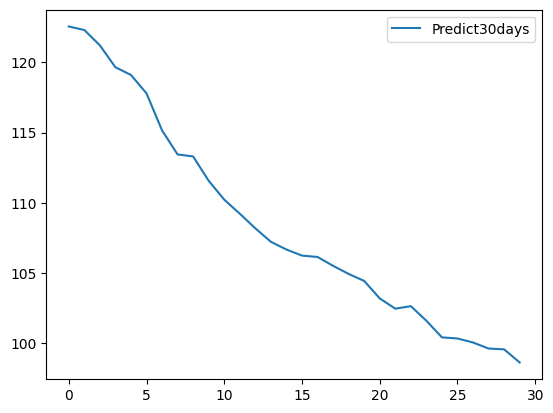

In [96]:
# 15.Vẽ hình Predict 30 days
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()

In [97]:
scaler.inverse_transform(lst_output)[:30, 0]

array([122.54930952, 122.29808603, 121.20613576, 119.64757828,
       119.09890108, 117.78824287, 115.15534619, 113.44206737,
       113.29943491, 111.56473942, 110.22454474, 109.22410122,
       108.18362179, 107.22547574, 106.67579038, 106.24465962,
       106.14644086, 105.5156937 , 104.94015939, 104.44166331,
       103.19572739, 102.46707936, 102.64540626, 101.60782417,
       100.42503926, 100.34543974, 100.06104676,  99.63047912,
        99.572487  ,  98.63807366])